# Extract data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data = pd.read_parquet("../data/train.parquet")
data.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X772,X773,X774,X775,X776,X777,X778,X779,X780,label
2023-03-01 00:00:00,15.283,8.425,176.405,44.984,221.389,0.181844,-0.637860,0.006652,0.136870,0.116698,...,0.333753,-0.009992,-0.695595,-0.444077,-0.191238,-0.184251,-0.471897,-0.625428,-0.553991,0.562539
2023-03-01 00:01:00,38.590,2.336,525.846,321.950,847.796,0.489497,-0.075619,0.431594,0.522400,0.475255,...,0.333657,-0.010040,-0.696226,-0.452866,-0.200082,-0.188929,-0.472842,-0.625832,-0.554426,0.533686
2023-03-01 00:02:00,0.442,60.250,159.227,136.369,295.596,0.260121,-0.444684,0.100695,0.224729,0.203282,...,0.333667,-0.010037,-0.696832,-0.461383,-0.208786,-0.193571,-0.473785,-0.626236,-0.554860,0.546505
2023-03-01 00:03:00,4.865,21.016,335.742,124.963,460.705,0.099976,-0.666728,-0.123858,0.019197,0.014459,...,0.333174,-0.010279,-0.697391,-0.469628,-0.217350,-0.198175,-0.474726,-0.626639,-0.555294,0.357703
2023-03-01 00:04:00,27.158,3.451,98.411,44.407,142.818,0.270893,-0.325973,0.116336,0.234311,0.214073,...,0.333171,-0.010283,-0.697940,-0.477622,-0.225780,-0.202745,-0.475666,-0.627043,-0.555728,0.362452


In [5]:
x_data = data.iloc[:, 5:-1].copy()

In [6]:
y_data = data.iloc[:, -1].copy()

In [4]:
# Clean uninformative cols
print([col for col in x_data.columns if x_data[col].nunique() == 1])

[]


In [5]:
x_data_with_target = x_data.copy()
x_data_with_target["label"] = data["label"]

In [5]:
import gc

del data
# del x_data
gc.collect()

0

# LGBM feature importance

In [17]:
import lightgbm

In [ ]:
params = {
    "n_estimators": 1000,
    "max_depth": 10,
    "learning_rate": 0.048,
    "subsample": 0.88,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.018,
    "reg_lambda": 0.33,
    "min_child_samples": 36,
    "objective": "regression",
    "random_state": 0,
    "verbosity": -1,
}

In [20]:
model = lightgbm.LGBMRegressor(**params)

model.fit(x_data, y_data)

feat_imp_df = pd.DataFrame({
    "feature": model.booster_.feature_name(),
    "importance": model.booster_.feature_importance(importance_type='gain'),
})

print(feat_imp_df.sort_values(by="importance", ascending=False).head(100)["feature"].tolist())

['X862', 'X890', 'X785', 'X889', 'X466', 'X888', 'X854', 'X853', 'X180', 'X174', 'X887', 'X883', 'X605', 'X425', 'X344', 'X341', 'X537', 'X852', 'X695', 'X786', 'X343', 'X97', 'X445', 'X873', 'X98', 'X427', 'X598', 'X284', 'X385', 'X96', 'X540', 'X612', 'X686', 'X586', 'X421', 'X530', 'X689', 'X272', 'X604', 'X856', 'X882', 'X886', 'X292', 'X345', 'X383', 'X178', 'X138', 'X95', 'X696', 'X465', 'X181', 'X863', 'X136', 'X855', 'X692', 'X533', 'X422', 'X428', 'X688', 'X840', 'X279', 'X685', 'X680', 'X132', 'X603', 'X90', 'X673', 'X198', 'X137', 'X332', 'X94', 'X874', 'X784', 'X339', 'X881', 'X662', 'X415', 'X668', 'X443', 'X674', 'X841', 'X444', 'X40', 'X885', 'X173', 'X691', 'X342', 'X690', 'X419', 'X693', 'X588', 'X219', 'X539', 'X384', 'X413', 'X282', 'X331', 'X758', 'X179', 'X380']


# Correlations of X with y

In [8]:
correlations = (
    x_data_with_target
    .drop(columns="label")
    .corrwith(x_data_with_target["label"])
    .sort_values(ascending=False)
)
print(correlations)

X21     0.069401
X20     0.067667
X28     0.064092
X863    0.064057
X29     0.062339
          ...   
X580   -0.041725
X95    -0.042948
X137   -0.044290
X524   -0.048020
X531   -0.056184
Length: 863, dtype: float64


In [9]:
top_percentile = np.percentile(x_data_with_target["label"], 95)
bot_percentile = np.percentile(x_data_with_target["label"], 5)

x_data_extreme_top = x_data_with_target[x_data_with_target["label"] > top_percentile]
x_data_extreme_bot = x_data_with_target[x_data_with_target["label"] < bot_percentile]
x_data_extreme = pd.concat([x_data_extreme_top, x_data_extreme_bot])

In [10]:
del x_data_with_target
gc.collect()

0

In [11]:
for df in [x_data_extreme_top, x_data_extreme_bot, x_data_extreme]:
    correlations = (
        df
        .drop(columns="label")
        .corrwith(df["label"])
        .sort_values(ascending=False)
    )
    print(correlations)

X849    0.181019
X205    0.178474
X729    0.176885
X181    0.176761
X175    0.176409
          ...   
X173   -0.185095
X426   -0.186230
X179   -0.187539
X420   -0.199055
X414   -0.204036
Length: 863, dtype: float64
X841    0.185548
X837    0.183585
X833    0.181078
X221    0.180494
X777    0.177421
          ...   
X594   -0.185491
X9     -0.190387
X879   -0.192173
X878   -0.216843
X877   -0.236934
Length: 863, dtype: float64
X181    0.184705
X471    0.184108
X856    0.182991
X175    0.182231
X472    0.181195
          ...   
X9     -0.170084
X137   -0.173009
X131   -0.174823
X524   -0.186248
X531   -0.206567
Length: 863, dtype: float64


# PCA

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

pca = PCA()
x_data = pca.fit_transform(x_data)

pca_eigval = pca.explained_variance_

# Kaiser's criterion
n_components = (pca.explained_variance_ > 1).sum()
print(n_components)
print(x_data)

113
[[-8.74548326e+00  5.33448666e+00  1.23959013e-01 ... -2.07260259e-11
  -3.96066682e-10 -4.79068294e-10]
 [-8.05766245e+00  5.40718040e+00 -9.01364442e-02 ...  9.21393773e-12
  -2.06310305e-09  3.62645878e-10]
 [-8.28078387e+00  4.98586867e+00 -1.73311187e-01 ...  2.13921263e-11
  -2.01046679e-09  5.22234190e-10]
 ...
 [-1.80864124e+00 -1.73339974e+00 -4.60765365e+00 ...  6.30344442e-11
  -1.50106663e-09  8.83248499e-10]
 [-3.11439931e+00 -2.78814793e+00 -4.24705417e+00 ...  8.20620507e-11
  -3.33879759e-09 -8.61553786e-10]
 [-8.12459482e+00 -7.47615005e+00 -1.48260459e+00 ... -8.20150878e-11
  -1.23518739e-09 -3.75789296e-09]]


In [ ]:
print(pca.explained_variance_ratio_[:n_components].sum())

0.9001244687052725


# Mutual Info Selection

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [ ]:
selector = SelectKBest(score_func=mutual_info_regression, k=400)
selector.fit(x_data, y_data)

,score_func,<function mut...001A3356004A0>
,k,400


In [10]:
print(list(x_data.columns[selector.get_support()]))

['X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X73', 'X74', 'X77', 'X79', 'X80', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X103', 'X109', 'X113', 'X115', 'X116', 'X119', 'X121', 'X122', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X145', 'X151', 'X155', 'X157', 'X158', 'X161', 'X163', 'X164', 'X166', 'X167', 'X168', 'X169', 'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178', 'X179', 'X180', 'X181', 'X182', 'X183', 'X184', 'X186', 'X198', 'X214', 'X215', 'X216', 'X217', 'X218', 'X219', 'X234', 'X235', 'X236', 'X237', 'X238', 'X239', 'X240', 'X241', 'X242', 'X243', 'X244', 'X245', 'X246', 'X247', 'X269', 'X270', 'X271', 'X272', 'X277', 'X279', 'X280', 'X281', 'X282', 'X283', 'X284

# Cross-correlations

In [6]:
corr_matrix = np.corrcoef(x_data.values, rowvar=False)
distance_matrix = 1 - abs(corr_matrix)
col_names = x_data.columns

In [7]:
print(corr_matrix.shape)
print(len(col_names))

(780, 780)
780


In [35]:
from sklearn.linear_model import LinearRegression

corr_matrix_df = pd.DataFrame(corr_matrix, index=col_names, columns=col_names)

X = corr_matrix_df[["X877", "X883"]]
y = corr_matrix_df["X878"]

model = LinearRegression().fit(X, y)
print(model.score(X, y))

0.9759491890423727


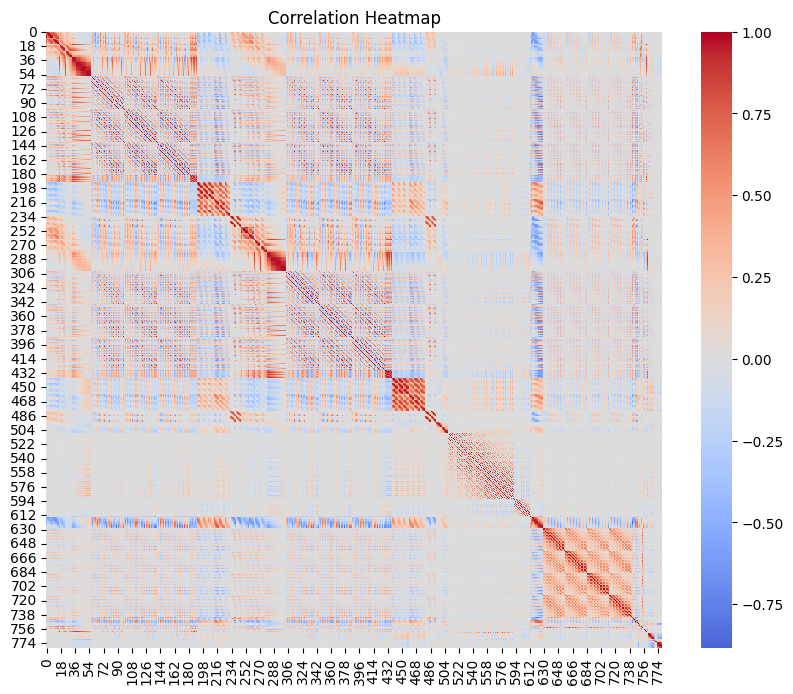

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
corr_matrix_df = pd.DataFrame(corr_matrix, index=col_names, columns=col_names)

to_drop = set()
for i in range(len(corr_matrix_df.columns)):
    if corr_matrix_df.columns[i] in to_drop:
        continue
    for j in range(i+1, len(corr_matrix_df.columns)):
        if corr_matrix_df.columns[j] in to_drop:
            continue
        if abs(corr_matrix_df.iloc[i, j]) > 0.95:
            to_drop.add(corr_matrix_df.columns[j])

print(list(to_drop))
print(len(to_drop))

['X290', 'X246', 'X320', 'X285', 'X493', 'X200', 'X295', 'X90', 'X580', 'X500', 'X527', 'X411', 'X619', 'X712', 'X297', 'X186', 'X259', 'X293', 'X465', 'X489', 'X655', 'X134', 'X253', 'X691', 'X158', 'X659', 'X699', 'X735', 'X44', 'X156', 'X251', 'X87', 'X387', 'X492', 'X542', 'X182', 'X403', 'X4', 'X399', 'X244', 'X568', 'X361', 'X663', 'X768', 'X262', 'X255', 'X494', 'X339', 'X577', 'X456', 'X300', 'X621', 'X778', 'X442', 'X765', 'X52', 'X282', 'X31', 'X46', 'X7', 'X450', 'X739', 'X556', 'X270', 'X419', 'X284', 'X773', 'X116', 'X625', 'X375', 'X566', 'X627', 'X629', 'X188', 'X303', 'X204', 'X623', 'X687', 'X48', 'X135', 'X243', 'X35', 'X205', 'X490', 'X583', 'X337', 'X16', 'X38', 'X128', 'X40', 'X281', 'X54', 'X588', 'X104', 'X157', 'X617', 'X333', 'X434', 'X152', 'X369', 'X488', 'X43', 'X667', 'X242', 'X703', 'X565', 'X393', 'X381', 'X72', 'X301', 'X345', 'X451', 'X327', 'X520', 'X433', 'X110', 'X174', 'X164', 'X362', 'X651', 'X740', 'X47', 'X357', 'X647', 'X599', 'X56', 'X447', 'X7

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(x_data.values, i) for i in range(x_data.values.shape[1])]
print(max(vif))

In [7]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from collections import defaultdict

In [9]:
linkage_matrix = linkage(squareform(distance_matrix, checks=False), method='ward')

In [10]:
print(linkage_matrix.shape)

(834, 4)


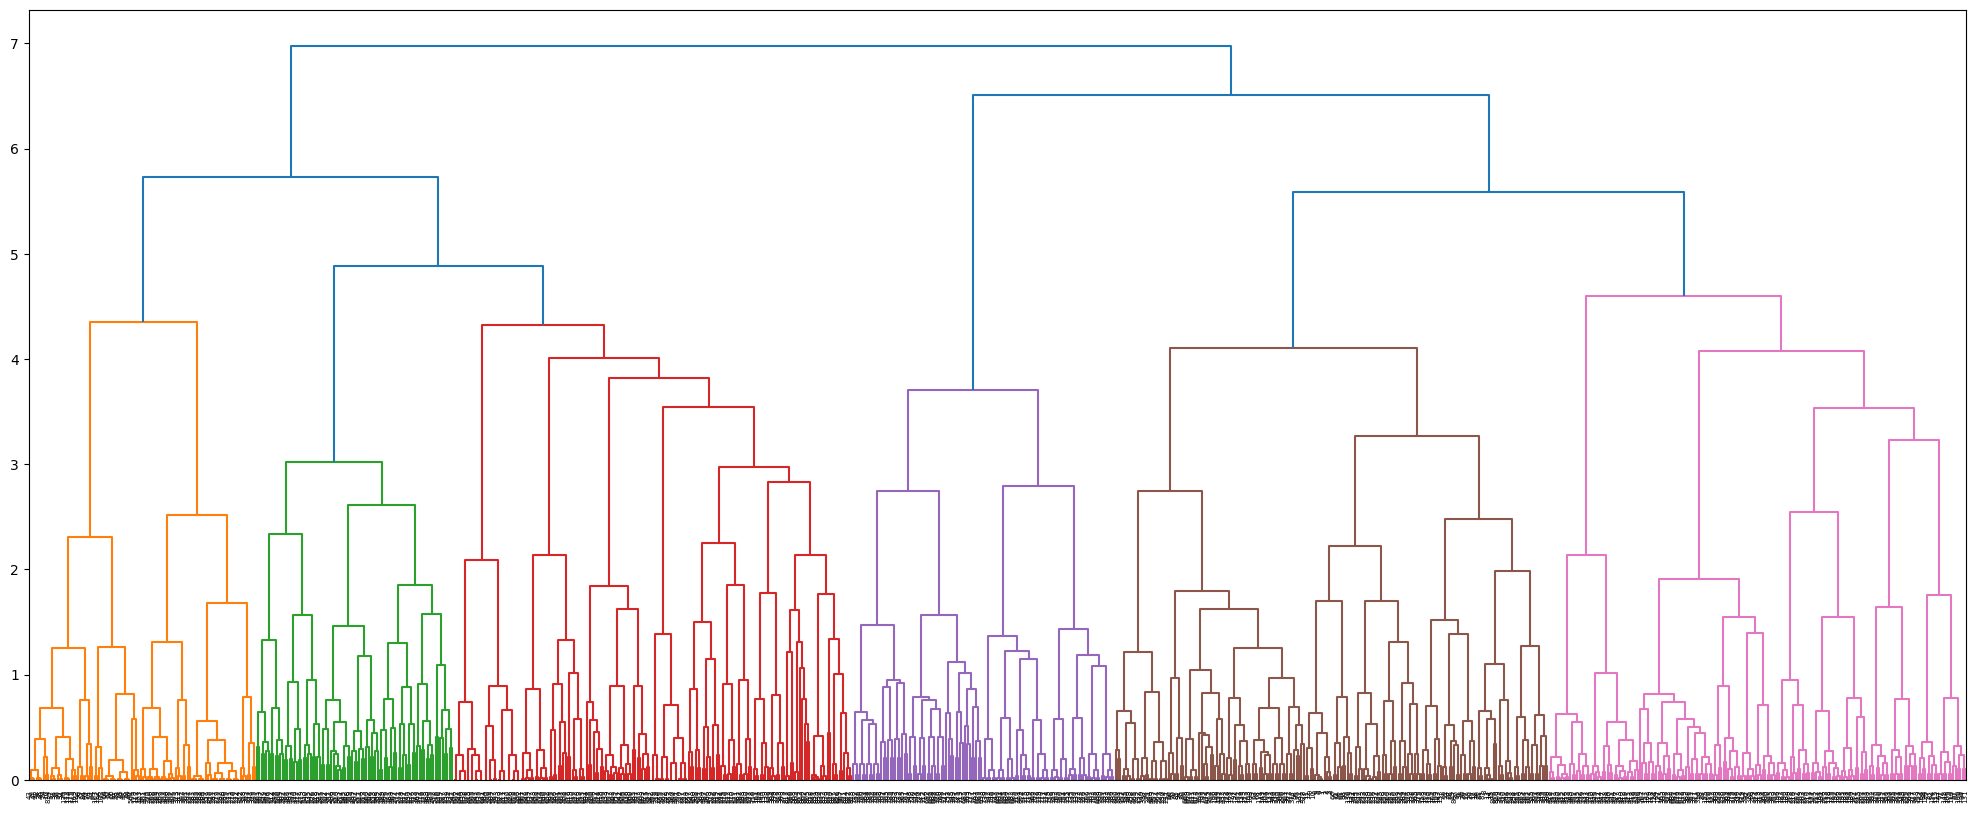

In [11]:
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_matrix)
plt.show()

In [12]:
n_clusters = 6
cluster_feature_dict = defaultdict(set)

In [13]:
clusters = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

In [14]:
for i in range(clusters.shape[0]):
    cluster_feature_dict[clusters[i]].add(col_names[i])

In [57]:
print(cluster_feature_dict)

defaultdict(<class 'set'>, {np.int32(5): {'X247', 'X487', 'X11', 'X163', 'X107', 'X186', 'X266', 'X15', 'X486', 'X358', 'X252', 'X357', 'X460', 'X274', 'X257', 'X239', 'X259', 'X158', 'X87', 'X16', 'X322', 'X334', 'X57', 'X340', 'X354', 'X461', 'X135', 'X155', 'X857', 'X145', 'X255', 'X99', 'X269', 'X115', 'X249', 'X304', 'X418', 'X262', 'X328', 'X6', 'X263', 'X77', 'X13', 'X324', 'X275', 'X23', 'X351', 'X10', 'X278', 'X21', 'X63', 'X363', 'X67', 'X273', 'X279', 'X28', 'X258', 'X261', 'X310', 'X396', 'X390', 'X20', 'X248', 'X360', 'X157', 'X105', 'X97', 'X2', 'X73', 'X143', 'X71', 'X177', 'X165', 'X848', 'X81', 'X720', 'X1', 'X271', 'X723', 'X318', 'X860', 'X101', 'X159', 'X254', 'X724', 'X406', 'X24', 'X59', 'X149', 'X412', 'X12', 'X22', 'X129', 'X31', 'X721', 'X27', 'X411', 'X123', 'X238', 'X276', 'X14', 'X29', 'X111', 'X346', 'X846', 'X103', 'X147', 'X7', 'X18', 'X312', 'X251', 'X722', 'X402', 'X93', 'X277', 'X256', 'X141', 'X394', 'X348', 'X849', 'X267', 'X171', 'X91', 'X26', 'X493

# SHAP with XGBoost

In [7]:
import xgboost
import shap

c:\Users\armin\Documents\GitHub\kaggle-crypto-market-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model_xgb = xgboost.XGBRegressor(n_estimators=1000, max_depth=5).fit(x_data, y_data)

x_data_sample = shap.utils.sample(x_data, 1000)

explainer_xgb = shap.Explainer(model_xgb, x_data_sample)
shap_values_xgb = explainer_xgb(x_data)

100%|===================| 525845/525887 [265:29<00:01]         

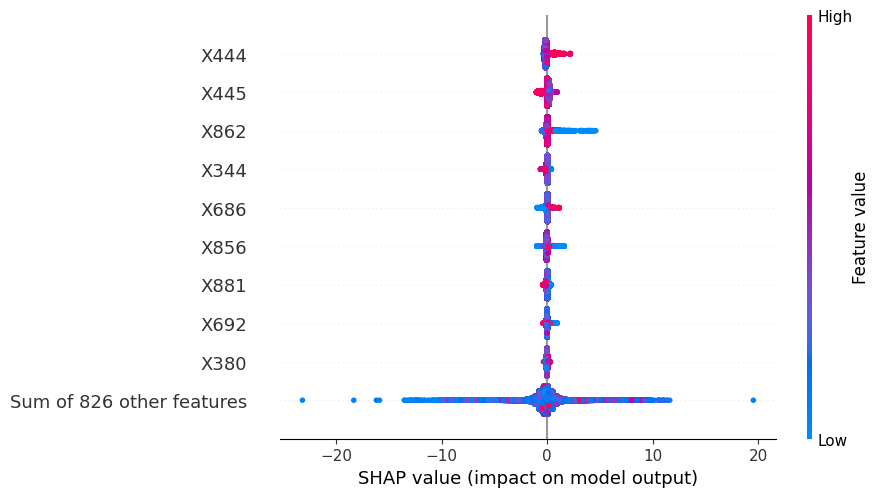

In [11]:
shap.plots.beeswarm(shap_values_xgb)

In [ ]:
import h5py

with h5py.File('shap_values_xgb.h5', 'w') as f:
    f.create_dataset('shap_values', data=shap_values_xgb)

In [ ]:
with h5py.File('shap_values_xgb.h5', 'r') as f:
    loaded_arr = f['shap_values'][:]

# Feature plotting

In [10]:
import plotly.io as pio
pio.renderers.default = "browser"

import plotly.graph_objects as go
from scipy import stats

In [ ]:
feature = x_data["X862"]

In [ ]:
print(f"mean: {np.mean(feature)}")
print(f"std: {np.std(feature)}")
print(f"skewness: {stats.skew(feature)}")
print(f"kurtosis: {stats.kurtosis(feature)}")
print("--------------------------------")
print(f"max: {np.max(feature)}")
print(f"min: {np.min(feature)}")
print("--------------------------------")
print(f"25th percentile: {np.percentile(feature, 25)}")
print(f"50th percentile: {np.median(feature)}")
print(f"75th percentile: {np.percentile(feature, 75)}")

In [ ]:
figure = go.Figure()

figure.add_trace(
    go.Scatter(
        x = feature.index,
        y = feature.values,
        mode = "lines",
        name = "Price"
    )
)
figure.update_layout(
    title = "Price movement",
    xaxis_title = "Time",
    yaxis_title = "Price"
)

figure.show()

In [ ]:
figure = go.Figure()

figure.add_trace(go.Histogram(x=feature.values))
figure.update_layout(title = "Price Frequency Histogram")

figure.show()